In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import lasso_path


In [2]:
# Your path
xlsx_path = r"C:\Users\User\Desktop\CausalAI-Course\data\Districtwise_literacy_rates.xlsx"

"""
Load Excel and drop rows with any missing values.

Parameters
----------
xlsx_path : str
    Absolute path to the Excel file.

Returns
-------
df : pd.DataFrame
    Cleaned dataset with no NAs.
"""
def load_and_clean(xlsx_path: str) -> pd.DataFrame:
    df = pd.read_excel(xlsx_path)
    df = df.dropna(axis=0, how="any")
    return df

df = load_and_clean(xlsx_path)
df.shape


(625, 100)

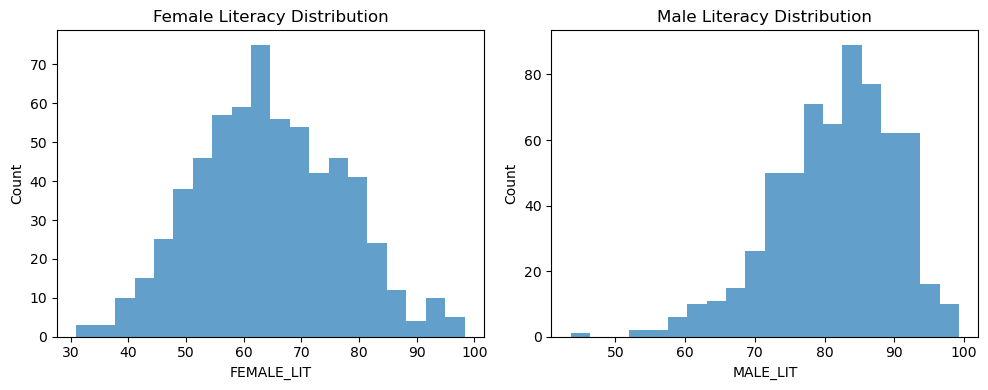

In [3]:
"""
Plot histograms for female and male literacy rates.

Parameters
----------
df : pd.DataFrame
    Must contain 'FEMALE_LIT' and 'MALE_LIT'.

Returns
-------
None
"""
def plot_histograms(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(df["FEMALE_LIT"], bins=20, alpha=0.7)
    ax[0].set_title("Female Literacy Distribution")
    ax[0].set_xlabel("FEMALE_LIT"); ax[0].set_ylabel("Count")

    ax[1].hist(df["MALE_LIT"], bins=20, alpha=0.7)
    ax[1].set_title("Male Literacy Distribution")
    ax[1].set_xlabel("MALE_LIT"); ax[1].set_ylabel("Count")
    plt.tight_layout(); plt.show()

plot_histograms(df)


### Comentario sobre las distribuciones de alfabetización

- **Alfabetización femenina (FEMALE_LIT):**  
  La distribución se concentra principalmente entre **50% y 80%**, con un pico en torno a **60–65%**. Presenta mayor dispersión y existen distritos con niveles relativamente bajos.

- **Alfabetización masculina (MALE_LIT):**  
  La distribución está desplazada hacia la derecha, concentrándose entre **70% y 90%**. La mayoría de los distritos muestran niveles altos y la dispersión es menor en comparación con las mujeres.

- **Conclusión:**  
  Se observa una **brecha sistemática de género**: la alfabetización masculina tiende a ser **mayor y más homogénea** que la femenina.


In [4]:
# Predictors chosen for the simple model
LOW_PRED = ["TOTPOPULAT", "P_URB_POP", "SEXRATIO"]

"""
Train/test split. Fit OLS with few predictors. Report test R^2.

R^2_test = 1 - SSR/SST, with SSR = Σ(y - ŷ)^2 on test.

Parameters
----------
df : pd.DataFrame
    Clean dataset.
y_col : str
    Target column name.
pred_cols : list[str]
    Selected predictors.

Returns
-------
r2_test : float
    Out-of-sample R^2 on the test set.
model : sklearn.linear_model.LinearRegression
    Trained linear model.
X_test, y_test, y_pred : arrays
    Holdout design, truth, and predictions.
"""
def low_dim_r2(df, y_col="FEMALE_LIT", pred_cols=LOW_PRED):
    X = df[pred_cols].to_numpy(dtype=float)
    y = df[y_col].to_numpy(dtype=float)

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=123)

    # Standardize features for stability in flexible steps later
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_te_s = scaler.transform(X_te)

    ols = LinearRegression().fit(X_tr_s, y_tr)
    y_hat = ols.predict(X_te_s)
    return r2_score(y_te, y_hat), ols, (X_te_s, y_te, y_hat), scaler

r2_low, ols_low, (Xte_low, yte_low, yhat_low), scaler_low = low_dim_r2(df)
print(f"Low-dimensional spec — Test R^2: {r2_low:.3f}")


Low-dimensional spec — Test R^2: 0.277


In [5]:
HD_PRED = ["TOTPOPULAT", "P_URB_POP", "SEXRATIO", "AREA_SQKM", "GROWTHRATE"]

"""
Build a flexible design: main effects + all 2-way interactions + squares.
Fit OLS on train. Compute test R^2.

Design = PolyFeatures(degree=2, include_bias=False, interaction_only=False)

Parameters
----------
df : pd.DataFrame
y_col : str
pred_cols : list[str]

Returns
-------
r2_test : float
"""
def high_dim_r2(df, y_col="FEMALE_LIT", pred_cols=HD_PRED):
    X = df[pred_cols].to_numpy(dtype=float)
    y = df[y_col].to_numpy(dtype=float)

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=123)

    poly = PolynomialFeatures(degree=2, include_bias=False)  # mains + squares + pairwise interactions
    X_tr_poly = poly.fit_transform(X_tr)
    X_te_poly = poly.transform(X_te)

    scaler = StandardScaler().fit(X_tr_poly)
    X_tr_s = scaler.transform(X_tr_poly)
    X_te_s = scaler.transform(X_te_poly)

    ols = LinearRegression().fit(X_tr_s, y_tr)
    y_hat = ols.predict(X_te_s)
    return r2_score(y_te, y_hat)

r2_high = high_dim_r2(df)
print(f"Flexible spec — Test R^2: {r2_high:.3f}")


Flexible spec — Test R^2: 0.414


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lasso_path
import numpy as np
import matplotlib.pyplot as plt

def lasso_nnz_path(df, y_col="FEMALE_LIT",
                   pred_cols=("TOTPOPULAT","P_URB_POP","SEXRATIO","AREA_SQKM","GROWTHRATE"),
                   lmin=1e-3, lmax=1e4):
    X = df[list(pred_cols)].to_numpy(dtype=float)
    y = df[y_col].to_numpy(dtype=float)

    # estandarizar X y centrar y (intercepto absorbido)
    X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
    y = y - y.mean()

    # grid de lambdas: 10,000 → 0.001 en orden descendente
    alphas = np.logspace(np.log10(lmax), np.log10(lmin), num=200)[::-1]

    # lasso_path no tiene fit_intercept
    alphas_out, coefs, _ = lasso_path(X, y, alphas=alphas)

    nnz = (coefs != 0).sum(axis=0)

    plt.figure(figsize=(6,5))
    plt.plot(np.log(alphas_out), nnz, lw=1.5)
    plt.xlabel("log(lambda)"); plt.ylabel("Nonzero coefficients")
    plt.title("Lasso path: # nonzero coefficients")
    plt.grid(True, alpha=0.3)
    plt.show()

    return alphas_out, nnz


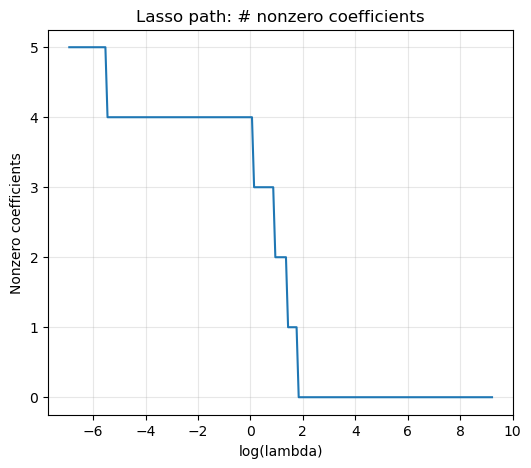

In [8]:
alphas_out, nnz = lasso_nnz_path(df)


### Comentario sobre el camino del Lasso

- **Valores grandes de λ (penalización alta):**  
  Todos los coeficientes se reducen a **cero**, lo que implica que el modelo no utiliza ninguna variable explicativa.

- **Valores intermedios de λ:**  
  A medida que la penalización disminuye, **aparecen gradualmente más coeficientes distintos de cero**. El número de variables seleccionadas crece de forma escalonada.

- **Valores pequeños de λ (penalización baja):**  
  El modelo mantiene hasta **5 predictores activos**, reflejando una mayor flexibilidad pero también un mayor riesgo de sobreajuste.

- **Conclusión:**  
  El gráfico ilustra la **propiedad de selección de variables del Lasso**: con penalización fuerte se eliminan variables irrelevantes, y con penalización débil se incluyen más predictores.
